# convnet 中間出力画像の作成

入力画像ファイルと出力先ディレクトリを指定して VGG16 のすべてのフィルタごとの反応画像を出力します。

実行前に以下のライブラリを導入する必要があります。

```
$ apt install -y libsm6 libxext6 libfontconfig1 libxrender1
$ pip install opencv-python keras numpy
```

In [1]:
input_file = "kawasemi.jpg"
output_dir = "filtered-images_vgg16_kawasemi"

## 画像の読み込み

入力画像を読み込んで、Keras に付属の ImageNet 学習済み VGG16 と適合するように前処理をしたテンソルとして保持します。

IMAGE: (1, 224, 224, 3)


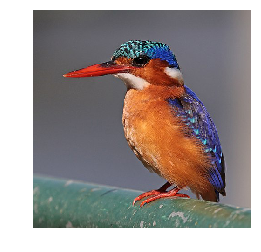

In [5]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = image.load_img(input_file, target_size=(224, 224))
plt.axis("off")
plt.imshow(img)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
print("IMAGE: %s" % str(img.shape))



次に、VGG16 のモデルから畳み込み層のレイヤーだけを取り出して活性化モデルを作成します。

In [11]:
from keras import models
from keras.applications.vgg16 import VGG16

model = VGG16(weights="imagenet")
layers = model.layers[1:19]
layer_outputs = [layer.output for layer in layers]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# activation_model.summary()

activations = activation_model.predict(img)
# for i, activation in enumerate(activations):
#   print("%2d: %s" % (i, str(activation.shape)))

18 18


## フィルタ強度画像の作成

レイヤーの各フィルタを通過した画像がどの部分を特徴として強調されているかを可視化する画像を作成します。

ヒートマップのように表示されるようにカラーマップを使用しています。

(64, 224, 224, 4) -> 8x8 write to: filtered-images_vgg16_kawasemi/block1_conv1.png (1799, 1799, 4)
(64, 224, 224, 4) -> 8x8 write to: filtered-images_vgg16_kawasemi/block1_conv2.png (1799, 1799, 4)
(64, 112, 112, 4) -> 8x8 write to: filtered-images_vgg16_kawasemi/block1_pool.png (903, 903, 4)
(128, 112, 112, 4) -> 11x12 write to: filtered-images_vgg16_kawasemi/block2_conv1.png (1242, 1355, 4)
(128, 112, 112, 4) -> 11x12 write to: filtered-images_vgg16_kawasemi/block2_conv2.png (1242, 1355, 4)
(128, 56, 56, 4) -> 11x12 write to: filtered-images_vgg16_kawasemi/block2_pool.png (626, 683, 4)
(256, 56, 56, 4) -> 16x16 write to: filtered-images_vgg16_kawasemi/block3_conv1.png (911, 911, 4)
(256, 56, 56, 4) -> 16x16 write to: filtered-images_vgg16_kawasemi/block3_conv2.png (911, 911, 4)
(256, 56, 56, 4) -> 16x16 write to: filtered-images_vgg16_kawasemi/block3_conv3.png (911, 911, 4)
(256, 28, 28, 4) -> 16x16 write to: filtered-images_vgg16_kawasemi/block3_pool.png (463, 463, 4)
(512, 28, 28, 

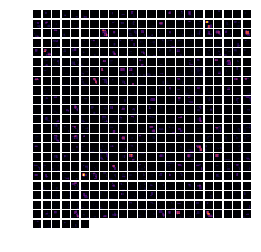

In [13]:
import os, math, cv2
from PIL import Image
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

if not os.path.isdir(output_dir):
  os.makedirs(output_dir)

cm = get_cmap("inferno")

for i, (activation, layer) in enumerate(zip(activations, layers)):
  num_of_images = activation.shape[3]
  output_file = os.path.join(output_dir, "%s.png" % layer.name)
  acts = (cm(activation[0, :, :] / np.max(activation[0])) * 255).astype(np.int8).transpose([2, 0, 1, 3])
  rows = math.ceil(math.sqrt(num_of_images))
  cols = math.ceil(num_of_images / rows)
  vstack = []
  spacing = 1
  for y in range(0, cols):
    size = min(rows, num_of_images - y * cols)
    hstack = []
    for x in range(0, rows):
      if x is not 0:
        hstack.append(np.zeros((acts[0].shape[0], spacing, 4), dtype=np.int8))
      i = y * cols + x
      if i < len(acts):
        hstack.append(acts[i])
      else:
        hstack.append(np.zeros(acts[0].shape, dtype=np.int8))
    row = cv2.hconcat(hstack)
    vstack.append(row)
    if y + 1 < cols:
      vstack.append(np.zeros((spacing, row.shape[1], 4), dtype=np.int8))
  array = cv2.vconcat(vstack)
  image = Image.fromarray(array, "RGBA")
  image.save(output_file)
  print("%s -> %dx%d write to: %s %s" % (str(acts.shape), cols, rows, output_file, str(array.shape)))

plt.axis("off")
plt.imshow(image)